In [1]:
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
from caveclient import CAVEclient
from datetime import datetime, timezone
settime3 = datetime(2023, 9, 19, 4, 0, 0, 0, tzinfo=timezone.utc)
client = CAVEclient('minnie65_phase3_v1')

In [2]:
fname = "Final_EM_MetType_Preds_RFC_Resamp_AllFeats_NoRadius"

In [3]:
##read in MET-type predictions from RFC
pred_df =  pd.read_csv("./NotebookInputs/Final_EM_MetType_Preds_RFC_Resamp_AllFeats_NoRadius.csv")

# #read in column paper connectivity-type labels 
col_mtype_df = client.materialize.query_table('allen_column_mtypes_v2', timestamp = settime3)
inh_mtype_df = col_mtype_df.loc[col_mtype_df['classification_system'] == 'inhibitory']
print (inh_mtype_df.head())

    id_ref                      created_ref valid_ref      volume  \
4   262898 2020-09-28 22:40:42.749245+00:00         t  230.092308   
5   269633 2020-09-28 22:40:42.782687+00:00         t  272.531128   
14  260718 2020-09-28 22:40:50.933063+00:00         t  206.650245   
18  256446 2020-09-28 22:40:51.343183+00:00         t  261.746688   
23  305251 2020-09-28 22:40:53.061119+00:00         t  279.089480   

     pt_supervoxel_id          pt_root_id    id  \
4   88468836747612860  864691135654475970  1405   
5   89529796883025209  864691136578765076  1357   
14  88607512718239945  864691135279181729  1396   
18  88532745726627869  864691136275240461  1324   
23  91641958787065738  864691135777888864  1340   

                            created valid  target_id classification_system  \
4  2023-08-21 22:53:35.262828+00:00     t     262898            inhibitory   
5  2023-08-21 22:53:35.226732+00:00     t     269633            inhibitory   
14 2023-08-21 22:53:35.256441+00:00     t   

In [4]:
##merge df of MET-type and connectivity-based cell type labels on cell ID ('pt_root_id' or 'id')
merge_df = inh_mtype_df.merge(pred_df, how = 'inner', left_on = 'pt_root_id', right_on = 'id')
###reduce size of df to critical columns
merge_df = merge_df[['cell_type', 'pt_root_id', 'predicted_MET-type Label', 'probability']]
merge_df['subclass'] = merge_df['predicted_MET-type Label'].str.split('-MET-').str[0]
##filter cells to those with a probability greater than 0.54 - the threshold determined for more likely to be accurate MET-type predictions
merge_df = merge_df.loc[merge_df['probability'] > 0.54]

<Axes: xlabel='MET Subclass', ylabel='Column type'>

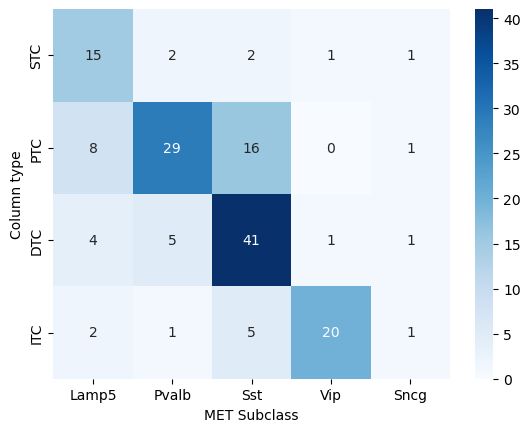

In [5]:
###plot a confusion matrix showing the number of cells of a predicted subclass from the MET-type vs the column connectivity label
# fname = 'Final_EM_MetType_Preds_RFC_Resamp_AllFeats_NoRadius'
confusion_mat = pd.crosstab(merge_df['cell_type'], merge_df['subclass'], rownames  = ['Column type'], colnames  = ['MET Subclass'], margins = False)
order_sub = ['Lamp5', 'Pvalb', 'Sst', 'Vip','Sncg']
order_targ = ['STC', 'PTC', 'DTC', 'ITC']
confusion_mat_reorder = confusion_mat.reindex(order_sub, axis = 'columns')
confusion_mat_reorder = confusion_mat_reorder.reindex(order_targ, axis = 'rows')
sn.heatmap (confusion_mat_reorder, cmap = "Blues", annot =True)
# plt.savefig('{}_subclass_pt54_reorder2_070524.pdf'.format(fname), bbox_inches='tight')


Predicted Subclass               Lamp5     Pvalb       Sst       Vip  Sncg
Targeting type (from column)                                              
STC                           0.517241  0.054054  0.031250  0.045455  0.25
PTC                           0.275862  0.783784  0.250000  0.000000  0.25
DTC                           0.137931  0.135135  0.640625  0.045455  0.25
ITC                           0.068966  0.027027  0.078125  0.909091  0.25


<Axes: xlabel='Predicted Subclass', ylabel='Targeting type (from column)'>

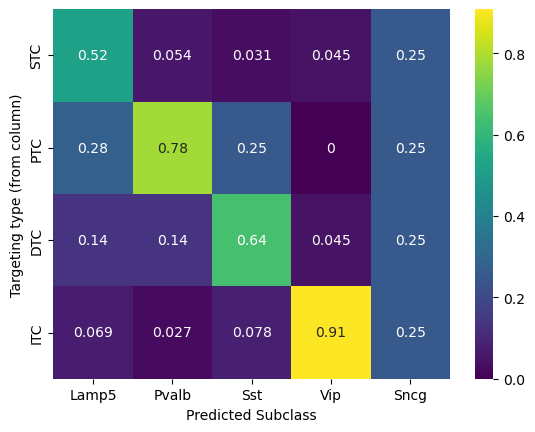

In [6]:
##note this plot is not included in the paper

###plot a confusion matrix showing the percentage of cells predicted subclass from the MET-type vs the column connectivity label
confusion_mat_norm = pd.crosstab(merge_df['cell_type'], merge_df['subclass'], rownames  = ['Targeting type (from column)'], colnames  = ['Predicted Subclass'], margins = False, normalize = 'columns')

confusion_mat_norm_reorder = confusion_mat_norm.reindex(order_sub, axis = 'columns')
confusion_mat_norm_reorder = confusion_mat_norm_reorder.reindex(order_targ, axis = 'rows')
print (confusion_mat_norm_reorder)
sn.heatmap (confusion_mat_norm_reorder, cmap = "viridis", annot =True)
# plt.savefig('{}_subclass_pt54_reorder2_viridis_normcol.pdf'.format(fname), bbox_inches='tight')


<Axes: xlabel='MET-type', ylabel='Column type'>

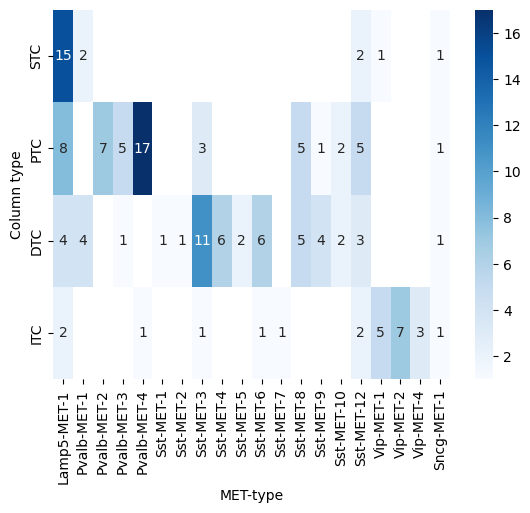

In [7]:
##note this plot is not included in the paper
###plot a confusion matrix showing the number of cells of a predicted MET-type vs the column connectivity label
confusion_mat = pd.crosstab(merge_df['cell_type'], merge_df['predicted_MET-type Label'], rownames  = ['Column type'], colnames  = ['MET-type'], margins = False)
order_sub = ['Lamp5-MET-1', 'Pvalb-MET-1', 'Pvalb-MET-2', 'Pvalb-MET-3', 'Pvalb-MET-4','Sst-MET-1','Sst-MET-2', 'Sst-MET-3','Sst-MET-4', 'Sst-MET-5','Sst-MET-6', 'Sst-MET-7','Sst-MET-8', 'Sst-MET-9', 'Sst-MET-10','Sst-MET-12','Vip-MET-1', 'Vip-MET-2','Vip-MET-4', 'Sncg-MET-1']
order_targ = ['STC', 'PTC', 'DTC', 'ITC']
confusion_mat_reorder = confusion_mat.reindex(order_sub, axis = 'columns')
confusion_mat_reorder = confusion_mat_reorder.reindex(order_targ, axis = 'rows')
sn.heatmap (confusion_mat_reorder, cmap = "Blues", annot =True, mask = confusion_mat_reorder < 1)
# plt.savefig('{}_met_pt54_reord.png'.format(fname), bbox_inches='tight')


In [8]:
print (merge_df.loc[merge_df['cell_type'] == 'PTC'])

    cell_type          pt_root_id predicted_MET-type Label  probability  \
5         PTC  864691135865968005                Sst-MET-3        0.952   
8         PTC  864691135693857727              Pvalb-MET-2        1.000   
9         PTC  864691135490940135              Pvalb-MET-4        0.894   
15        PTC  864691136662432990              Pvalb-MET-4        1.000   
16        PTC  864691135586352764                Sst-MET-3        0.756   
21        PTC  864691136117381284              Pvalb-MET-2        1.000   
23        PTC  864691136371168136              Lamp5-MET-1        0.904   
24        PTC  864691136904340658                Sst-MET-8        0.984   
28        PTC  864691135394307317                Sst-MET-3        0.828   
32        PTC  864691135568797676              Lamp5-MET-1        0.878   
37        PTC  864691136273259454              Pvalb-MET-3        0.722   
42        PTC  864691135777888352               Sst-MET-12        0.660   
43        PTC  8646911354